In [5]:
import requests
import datetime
import pandas as pd

from urllib.request import urlopen
from PIL import Image

#### API Parameter
|Parameter|Description|Required|Values|Example|
|---|---|---|---|---|
|q|Location|Required|City Name(, State)|New+York(, ny)|
|date||Required|yyyy-MM-dd||
|enddate|Need to have same month and year as date|Optional|yyyy-MM-dd||
|tp|Weather forecast time interval in hours|Optional|1, 3(default), 6, 12, 24||

In [8]:
def process_date_historical(date_year, date_month, date_day, enddate_year, enddate_month, enddate_day):
    '''
    return list of date --- yyyy-MM-dd
    '''
    startdate = datetime.datetime(year = date_year, month = date_month, day = date_day)
    enddate = datetime.datetime(year = enddate_year, month = enddate_month, day = enddate_day)
    
    start_timestamp = startdate.timestamp()
    end_timestamp = enddate.timestamp()
    
    if (start_timestamp > end_timestamp):
        raise ValueError ('Start date must not be later than end date!')
    
    curr_timestamp = start_timestamp
    
    dates = [] 
    while True:
        curr_datetime = datetime.datetime.fromtimestamp(curr_timestamp)
        curr_date_str = curr_datetime.strftime('%Y-%m-%d')
        dates.append(curr_date_str)
        if curr_timestamp == end_timestamp:
            break
        curr_timestamp += 60*60*24
        
    return dates

In [10]:
dates = process_date_historical(2019, 2, 27, 2019, 3, 5)
dates

['2019-02-27',
 '2019-02-28',
 '2019-03-01',
 '2019-03-02',
 '2019-03-03',
 '2019-03-04',
 '2019-03-05']

In [42]:
def load_data(location, dates):
    '''
    dates: list of date --- yyyy-MM-dd
    return: DataFrame
    '''
    interval = 1
    url = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    key = '8fefb61db8a241c4b7524155190612'
    fm = 'json'
    
    days_data = []
    days_hourly_data = []
    
    for day in dates:
        paras = dict()
        paras['key'] = key
        paras['format'] = fm
        paras['q'] = location
        paras['date'] = day
        paras['tp'] = interval
        
        r = requests.get(url, paras)
        r.raise_for_status()                                ### try and except? ###
        
        city = r.json()['data']['request'][0]['query']
        result = r.json()['data']['weather'][0]
        
        #################### day data ####################
        day_data = []
        day_data.append(result['date'])
        day_data.append(result['astronomy'][0]['sunrise'])
        day_data.append(result['astronomy'][0]['sunset'])
        day_data.append(result['astronomy'][0]['moonrise'])
        day_data.append(result['astronomy'][0]['moonset'])
        day_data.append(result['astronomy'][0]['moon_phase'])
        day_data.append(result['astronomy'][0]['moon_illumination'])
        day_data.append(result['maxtempC'])
        day_data.append(result['maxtempF'])
        day_data.append(result['mintempC'])
        day_data.append(result['mintempF'])
        day_data.append(result['avgtempC'])
        day_data.append(result['avgtempF'])
        day_data.append(result['totalSnow_cm'])
        day_data.append(result['sunHour'])
        day_data.append(result['uvIndex'])
        
        days_data.append(day_data)
        
        #################### hourly data ####################
        result_hourly = result['hourly']
        for hour in range(len(result_hourly)):
            result_hour = result_hourly[hour]
            hourly_data = []
            hourly_data.append('{} {}:00'.format(day, hour))
            hourly_data.append(result_hour['tempC'])
            hourly_data.append(result_hour['tempF'])
            hourly_data.append(result_hour['windspeedMiles'])
            hourly_data.append(result_hour['windspeedKmph'])
            hourly_data.append(result_hour['winddirDegree'])
            hourly_data.append(result_hour['winddir16Point'])
            hourly_data.append(result_hour['weatherIconUrl'][0]['value'])
            hourly_data.append(result_hour['weatherDesc'][0]['value'])
            hourly_data.append(result_hour['precipMM'])
            hourly_data.append(result_hour['precipInches'])
            hourly_data.append(result_hour['humidity'])
            hourly_data.append(result_hour['visibility'])
            hourly_data.append(result_hour['visibilityMiles'])
            hourly_data.append(result_hour['cloudcover'])
            hourly_data.append(result_hour['uvIndex'])
            days_hourly_data.append(hourly_data)
            
            
    
    df_day = pd.DataFrame(days_data, columns = ['date', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination',
                                                'maxtempC', 'maxtempF', 'mintempC', 'mintempF', 'avgtempC', 'avgtempF', 'totalSnow_cm',
                                                'sunHour', 'uvIndex'])
    df_hourly = pd.DataFrame(days_hourly_data, columns = ['date&time', 'tempC', 'tempF', 'windspeedMiles', 'windspeedKmph', 'winddirDegree',
                                                          'winddir16Point', 'weatherIconUrl', 'weatherDesc', 'precipMM', 'precipInches',
                                                          'humidity', 'visibility', 'visibilityMiles', 'cloudcover', 'uvIndex'])
    
    return df_day, df_hourly

In [44]:
df_day, df_hourly = load_data('providence', dates)

In [48]:
df_day.head()

,date,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination,maxtempC,maxtempF,mintempC,mintempF,avgtempC,avgtempF,totalSnow_cm,sunHour,uvIndex
0,2019-02-27,06:24 AM,05:34 PM,01:42 AM,11:27 AM,Last Quarter,35,-2,29,-10,14,-4,25,0.8,5.7,1
1,2019-02-28,06:22 AM,05:35 PM,02:38 AM,12:12 PM,Last Quarter,27,0,32,-8,18,-3,27,7.6,4.2,1
2,2019-03-01,06:21 AM,05:36 PM,03:30 AM,01:01 PM,Waning Crescent,26,4,40,-7,20,1,34,0.0,4.2,1
3,2019-03-02,06:19 AM,05:37 PM,04:16 AM,01:54 PM,Waning Crescent,19,4,40,-3,27,1,35,7.1,4.2,1
4,2019-03-03,06:18 AM,05:38 PM,04:56 AM,02:50 PM,Waning Crescent,12,4,40,-7,20,-0,32,0.9,8.7,1


In [47]:
df_hourly.head()

,date&time,tempC,tempF,windspeedMiles,windspeedKmph,winddirDegree,winddir16Point,weatherIconUrl,weatherDesc,precipMM,precipInches,humidity,visibility,visibilityMiles,cloudcover,uvIndex
0,2019-02-27 0:00,-8,19,6,10,310,NW,http://cdn.worldweatheronline.net/images/wsymb...,Partly cloudy,0.0,0.0,38,10,6,22,1
1,2019-02-27 1:00,-8,18,6,10,315,NW,http://cdn.worldweatheronline.net/images/wsymb...,Partly cloudy,0.0,0.0,39,10,6,27,1
2,2019-02-27 2:00,-9,17,6,9,319,NW,http://cdn.worldweatheronline.net/images/wsymb...,Partly cloudy,0.0,0.0,39,10,6,32,1
3,2019-02-27 3:00,-9,16,6,9,323,NW,http://cdn.worldweatheronline.net/images/wsymb...,Partly cloudy,0.0,0.0,39,10,6,37,1
4,2019-02-27 4:00,-9,16,6,10,328,NNW,http://cdn.worldweatheronline.net/images/wsymb...,Partly cloudy,0.0,0.0,40,10,6,32,1


## Understanding response --- Historical Data

In [6]:
paras = {'key':key, 'format':fm, 'q':'providence, ri', 'date':'2019-10-5', 'tp':1}
r = requests.get(url, paras)

In [10]:
r.json().keys()

dict_keys(['data'])

In [11]:
r.json()['data'].keys()

dict_keys(['request', 'weather'])

In [12]:
r.json()['data']['request']

[{'type': 'City', 'query': 'Providence, United States of America'}]

In [13]:
city = r.json()['data']['request'][0]['query']
city

'Providence, United States of America'

In [33]:
r.json()['data']['weather']

[{'date': '2019-10-05',
  'astronomy': [{'sunrise': '05:47 AM',
    'sunset': '05:21 PM',
    'moonrise': '01:15 PM',
    'moonset': '10:36 PM',
    'moon_phase': 'First Quarter',
    'moon_illumination': '41'}],
  'maxtempC': '19',
  'maxtempF': '67',
  'mintempC': '6',
  'mintempF': '43',
  'avgtempC': '14',
  'avgtempF': '58',
  'totalSnow_cm': '0.0',
  'sunHour': '11.6',
  'uvIndex': '1',
  'hourly': [{'time': '0',
    'tempC': '7',
    'tempF': '45',
    'windspeedMiles': '10',
    'windspeedKmph': '17',
    'winddirDegree': '242',
    'winddir16Point': 'WSW',
    'weatherCode': '113',
    'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
    'weatherDesc': [{'value': 'Clear'}],
    'precipMM': '0.0',
    'precipInches': '0.0',
    'humidity': '61',
    'visibility': '10',
    'visibilityMiles': '6',
    'pressure': '1026',
    'pressureInches': '31',
    'cloudcover': '0',
    'HeatIndexC': '7',
    'Heat

In [14]:
len(r.json()['data']['weather'])
# list of dictionary, each dictionary containing the data of weather in one day

1

In [15]:
r.json()['data']['weather'][0]

{'date': '2019-10-05',
 'astronomy': [{'sunrise': '05:47 AM',
   'sunset': '05:21 PM',
   'moonrise': '01:15 PM',
   'moonset': '10:36 PM',
   'moon_phase': 'First Quarter',
   'moon_illumination': '41'}],
 'maxtempC': '19',
 'maxtempF': '67',
 'mintempC': '6',
 'mintempF': '43',
 'avgtempC': '14',
 'avgtempF': '58',
 'totalSnow_cm': '0.0',
 'sunHour': '11.6',
 'uvIndex': '1',
 'hourly': [{'time': '0',
   'tempC': '7',
   'tempF': '45',
   'windspeedMiles': '10',
   'windspeedKmph': '17',
   'winddirDegree': '242',
   'winddir16Point': 'WSW',
   'weatherCode': '113',
   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
   'weatherDesc': [{'value': 'Clear'}],
   'precipMM': '0.0',
   'precipInches': '0.0',
   'humidity': '61',
   'visibility': '10',
   'visibilityMiles': '6',
   'pressure': '1026',
   'pressureInches': '31',
   'cloudcover': '0',
   'HeatIndexC': '7',
   'HeatIndexF': '45',
   'DewPointC': '0',


In [36]:
r.json()['data']['weather'][0].keys()

dict_keys(['date', 'astronomy', 'maxtempC', 'maxtempF', 'mintempC', 'mintempF', 'avgtempC', 'avgtempF', 'totalSnow_cm', 'sunHour', 'uvIndex', 'hourly'])

In [37]:
r.json()['data']['weather'][0]['astronomy']

[{'sunrise': '05:47 AM',
  'sunset': '05:21 PM',
  'moonrise': '01:15 PM',
  'moonset': '10:36 PM',
  'moon_phase': 'First Quarter',
  'moon_illumination': '41'}]

In [38]:
r.json()['data']['weather'][0]['hourly']

[{'time': '0',
  'tempC': '7',
  'tempF': '45',
  'windspeedMiles': '10',
  'windspeedKmph': '17',
  'winddirDegree': '242',
  'winddir16Point': 'WSW',
  'weatherCode': '113',
  'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
  'weatherDesc': [{'value': 'Clear'}],
  'precipMM': '0.0',
  'precipInches': '0.0',
  'humidity': '61',
  'visibility': '10',
  'visibilityMiles': '6',
  'pressure': '1026',
  'pressureInches': '31',
  'cloudcover': '0',
  'HeatIndexC': '7',
  'HeatIndexF': '45',
  'DewPointC': '0',
  'DewPointF': '33',
  'WindChillC': '5',
  'WindChillF': '40',
  'WindGustMiles': '15',
  'WindGustKmph': '25',
  'FeelsLikeC': '5',
  'FeelsLikeF': '40',
  'uvIndex': '1'},
 {'time': '1200',
  'tempC': '15',
  'tempF': '60',
  'windspeedMiles': '4',
  'windspeedKmph': '7',
  'winddirDegree': '17',
  'winddir16Point': 'NNE',
  'weatherCode': '113',
  'weatherIconUrl': [{'value': 'http://cdn.worldweatheronli

In [39]:
len(r.json()['data']['weather'][0]['hourly'])
# list of dictionary, each dictionary contains the data of weather in some interval

2

In [40]:
r.json()['data']['weather'][0]['hourly'][0]

{'time': '0',
 'tempC': '7',
 'tempF': '45',
 'windspeedMiles': '10',
 'windspeedKmph': '17',
 'winddirDegree': '242',
 'winddir16Point': 'WSW',
 'weatherCode': '113',
 'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
 'weatherDesc': [{'value': 'Clear'}],
 'precipMM': '0.0',
 'precipInches': '0.0',
 'humidity': '61',
 'visibility': '10',
 'visibilityMiles': '6',
 'pressure': '1026',
 'pressureInches': '31',
 'cloudcover': '0',
 'HeatIndexC': '7',
 'HeatIndexF': '45',
 'DewPointC': '0',
 'DewPointF': '33',
 'WindChillC': '5',
 'WindChillF': '40',
 'WindGustMiles': '15',
 'WindGustKmph': '25',
 'FeelsLikeC': '5',
 'FeelsLikeF': '40',
 'uvIndex': '1'}

In [42]:
r.json()['data']['weather'][0]['hourly'][0].keys()

dict_keys(['time', 'tempC', 'tempF', 'windspeedMiles', 'windspeedKmph', 'winddirDegree', 'winddir16Point', 'weatherCode', 'weatherIconUrl', 'weatherDesc', 'precipMM', 'precipInches', 'humidity', 'visibility', 'visibilityMiles', 'pressure', 'pressureInches', 'cloudcover', 'HeatIndexC', 'HeatIndexF', 'DewPointC', 'DewPointF', 'WindChillC', 'WindChillF', 'WindGustMiles', 'WindGustKmph', 'FeelsLikeC', 'FeelsLikeF', 'uvIndex'])

In [44]:
r.json()['data']['weather'][0]['hourly'][0]['weatherIconUrl']
# list of dictionary, len ???

[{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}]

In [52]:
icon_url = r.json()['data']['weather'][0]['hourly'][0]['weatherIconUrl'][0]['value']

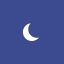

In [53]:
img = Image.open(urlopen(icon_url))
img

In [54]:
r.json()['data']['weather'][0]['hourly'][0]['weatherDesc']
# list of dictionary, len ???

[{'value': 'Clear'}]

In [56]:
r.json()['data']['weather'][0]['hourly'][0]['weatherDesc'][0]['value']

'Clear'